In [45]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram

In [46]:
#Define the three mutually unbiased bases (MUBs)
X_basis = [1, 0]
Y_basis = [1/np.sqrt(2), 1j/np.sqrt(2)]
Z_basis = [1/np.sqrt(2), -1/np.sqrt(2)]

In [47]:
n = 16
qr = QuantumRegister(n, name="qr")
cr = ClassicalRegister(n, name="cr")

In [48]:
alice = QuantumCircuit(qr, cr, name = 'Alice')

#generate a random sequence (bit) as the secret key
alice_key = np.random.randint(0, high = 2, size = n)
alice_bases = np.random.randint(0, high = 3, size = n) #0 for X, 1 for Y, 2 for Z

for index, (bit, basis) in enumerate(zip(alice_key, alice_bases)):
    if basis == 0:
        if bit == 0:
            alice.initialize(X_basis, qr[index])
        else:
            alice.x(qr[index])

    elif basis == 1:
        if bit == 0:
            alice.initialize(Y_basis, qr[index])
        else: 
            alice.y(qr[index])
    else: 
        if bit == 0:
            alice.initialize(Z_basis, qr[index])
        else:
            alice.z(qr[index])



In [49]:
bob = QuantumCircuit(qr, cr, name = 'Bob')

bob_bases = np.random.randint(0, high = 3, size = n)

In [50]:
for index, basis in enumerate(bob_bases):
    if basis == 0:
        bob.initialize(X_basis, qr[index])
    elif basis == 1:
        bob.initialize(Y_basis, qr[index])
    else: 
        bob.initialize(Z_basis, qr[index])

    bob.measure(qr[index], cr[index])

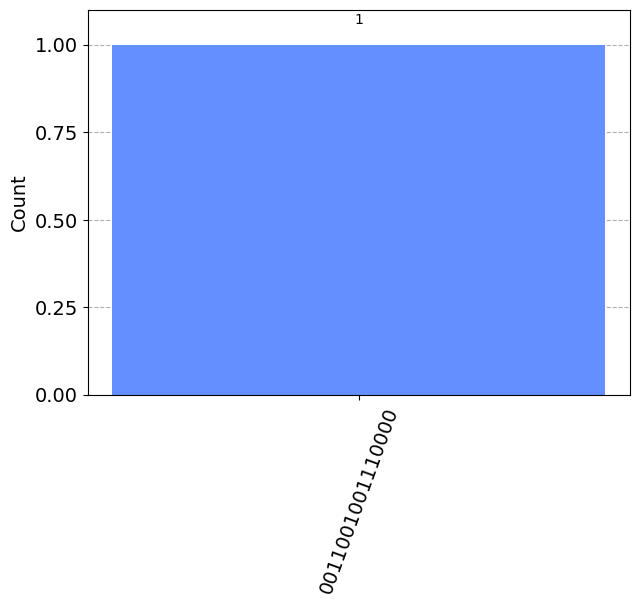

In [51]:
backend = BasicAer.get_backend("qasm_simulator")
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))

In [52]:
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [53]:
#Basic Reconciliation Process
keep = []
discard = []
for qubit, (alice_basis, bob_basis) in enumerate(zip(alice_bases, bob_bases)):
    if alice_basis == bob_basis:
        print(f"Same choice for qubit: {qubit}, basis: {alice_basis}")
        keep.append(qubit)
    else:
        print(
            f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Bob has {bob_basis}"
        )
        discard.append(qubit)

Different choice for qubit: 0, Alice has 2, Bob has 0
Different choice for qubit: 1, Alice has 0, Bob has 1
Different choice for qubit: 2, Alice has 2, Bob has 0
Different choice for qubit: 3, Alice has 1, Bob has 0
Different choice for qubit: 4, Alice has 2, Bob has 1
Different choice for qubit: 5, Alice has 0, Bob has 2
Different choice for qubit: 6, Alice has 2, Bob has 1
Same choice for qubit: 7, basis: 2
Different choice for qubit: 8, Alice has 1, Bob has 0
Different choice for qubit: 9, Alice has 2, Bob has 1
Different choice for qubit: 10, Alice has 1, Bob has 0
Different choice for qubit: 11, Alice has 0, Bob has 1
Different choice for qubit: 12, Alice has 0, Bob has 1
Same choice for qubit: 13, basis: 2
Different choice for qubit: 14, Alice has 1, Bob has 2
Different choice for qubit: 15, Alice has 1, Bob has 2


In [54]:
# Calculate % of qubits to be discarded and Measurement convergence
acc = sum(alice_key[qubit] == int(bob_key[qubit]) for qubit in keep)
print(
    "Percentage of qubits to be discarded according to basic reconciliation: ", (n - len(keep)) / n,
)
print("Measurement convergence by additional chance: ", acc / n)

Percentage of qubits to be discarded according to basic reconciliation:  0.875
Measurement convergence by additional chance:  0.0


In [55]:
# Extract the sifted keys after BR
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [int(bob_key[qubit]) for qubit in keep]

In [56]:
acc = sum(new_alice_key[i] == new_bob_key[i] for i in range(len(new_alice_key)))
print("Percentage of similarity between the sifted keys:", acc / len(new_alice_key))

if acc == len(new_alice_key):
    print("Key exchange has been successful")
    print("New Alice's key:", new_alice_key)
    print("New Bob's key:", new_bob_key)
else:
    print("Key exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid:", new_alice_key)
    print("New Bob's key is invalid:", new_bob_key)

Percentage of similarity between the sifted keys: 0.0
Key exchange has been tampered! Check for eavesdropper or try again
New Alice's key is invalid: [1, 0]
New Bob's key is invalid: [0, 1]


In [57]:
eve = QuantumCircuit(qr, cr, name="Eve")

In [58]:
eve_bases = np.random.randint(0, high=3, size=n)  # 0 for X, 1 for Y, 2 for Z

for index, basis in enumerate(eve_bases):
    if basis == 0:  # Measure in X basis
        eve.initialize(X_basis, qr[index])
    elif basis == 1:  # Measure in Y basis
        eve.initialize(Y_basis, qr[index])
    else:  # Measure in Z basis
        eve.initialize(Z_basis, qr[index])

    eve.measure(qr[index], cr[index])

In [59]:
result = execute(eve, backend=backend, shots=1).result()
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

In [60]:
for qubit, (alice_basis, eve_basis) in enumerate(zip(alice_bases, eve_bases)):
    if alice_basis != eve_basis:
        if alice_basis == 0:
            alice_basis = "X"
        elif alice_basis == 1:
            alice_basis = "Y"
        else:
            alice_basis = "Z"

        if eve_basis == 0:
            eve_basis = "X"
        elif eve_basis == 1:
            eve_basis = "Y"
        else:
            eve_basis = "Z"

        print(
            f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Eve has {eve_basis}"
        )

        if eve_key[qubit] == alice_key[qubit]:
            if alice_basis == "X":
                eve.h(qr[qubit])
            elif alice_basis == "Y":
                eve.y(qr[qubit])
            else:
                eve.z(qr[qubit])
        else:
            if alice_basis == "X" and eve_basis == "Z":
                eve.h(qr[qubit])
                eve.x(qr[qubit])
            elif alice_basis == "X" and eve_basis == "Y":
                eve.y(qr[qubit])
                eve.x(qr[qubit])
            elif alice_basis == "Y" and eve_basis == "X":
                eve.h(qr[qubit])
                eve.y(qr[qubit])
            elif alice_basis == "Y" and eve_basis == "Z":
                eve.z(qr[qubit])
                eve.x(qr[qubit])
            elif alice_basis == "Z" and eve_basis == "X":
                eve.h(qr[qubit])
                eve.z(qr[qubit])
            else:
                eve.y(qr[qubit])
                eve.z(qr[qubit])

Different choice for qubit: 0, Alice has Z, Eve has Y
Different choice for qubit: 1, Alice has X, Eve has Y
Different choice for qubit: 2, Alice has Z, Eve has X
Different choice for qubit: 4, Alice has Z, Eve has X
Different choice for qubit: 5, Alice has X, Eve has Y
Different choice for qubit: 8, Alice has Y, Eve has X
Different choice for qubit: 10, Alice has Y, Eve has X
Different choice for qubit: 11, Alice has X, Eve has Y
Different choice for qubit: 13, Alice has Z, Eve has X


In [61]:
for index in range(len(qr)):
    eve.measure(qr[index], cr[index])

result = execute(eve, backend=backend, shots=1).result()
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

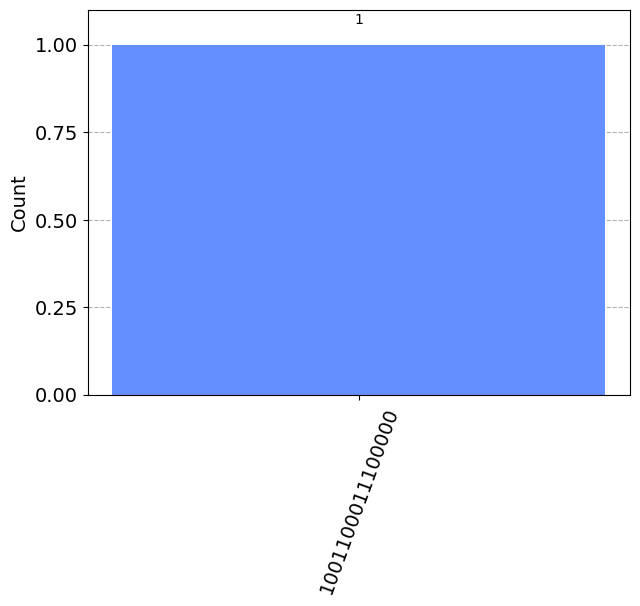

In [62]:
for index in range(len(qr)):
    bob.measure(qr[index], cr[index])

result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))



In [63]:
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [64]:
keep = []
discard = []
for qubit, (alice_basis, bob_basis) in enumerate(zip(alice_bases, bob_bases)):
    if alice_basis == bob_basis:
        print(f"Same choice for qubit: {qubit}, basis: {alice_basis}")
        keep.append(qubit)
    else:
        print(
            f"Different choice for qubit: {qubit}, Alice has {alice_basis}, Bob has {bob_basis}"
        )
        discard.append(qubit)

Different choice for qubit: 0, Alice has 2, Bob has 0
Different choice for qubit: 1, Alice has 0, Bob has 1
Different choice for qubit: 2, Alice has 2, Bob has 0
Different choice for qubit: 3, Alice has 1, Bob has 0
Different choice for qubit: 4, Alice has 2, Bob has 1
Different choice for qubit: 5, Alice has 0, Bob has 2
Different choice for qubit: 6, Alice has 2, Bob has 1
Same choice for qubit: 7, basis: 2
Different choice for qubit: 8, Alice has 1, Bob has 0
Different choice for qubit: 9, Alice has 2, Bob has 1
Different choice for qubit: 10, Alice has 1, Bob has 0
Different choice for qubit: 11, Alice has 0, Bob has 1
Different choice for qubit: 12, Alice has 0, Bob has 1
Same choice for qubit: 13, basis: 2
Different choice for qubit: 14, Alice has 1, Bob has 2
Different choice for qubit: 15, Alice has 1, Bob has 2


In [65]:
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [int(bob_key[qubit]) for qubit in keep]

# Check if the sifted keys match after Eve's interference
acc = sum(new_alice_key[i] == new_bob_key[i] for i in range(len(new_alice_key)))
print(
    "Percentage of similarity between the sifted keys (after Eve):",
    acc / len(new_alice_key),
)

if acc == len(new_alice_key):
    print("Key exchange has been successful (even after Eve's interference)")
else:
    print("Key exchange has been tampered by Eve!")

Percentage of similarity between the sifted keys (after Eve): 1.0
Key exchange has been successful (even after Eve's interference)


In [66]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.45.2', 'qiskit-aer': '0.14.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}